Cats vs Dogs 데이터셋으로 커스텀 이미지 로더를 만들고, 손상 이미지를 제거한 뒤, ResNet101 사전학습 모델을 미세조정해 이진 분류를 학습/평가할 수 있습니다.

핵심은 커스텀 Dataset 구현, 손상 이미지 검증/삭제, 최신 TorchVision의 weights 파라미터 사용, 그리고 전이학습을 위한 분류기 교체입니다.

파이프라인:

손상 이미지 제거→고정 라벨 매핑(Cat=0, Dog=1)→커스텀 Dataset→DataLoader→ResNet101 전이학습→평가

In [1]:
# Colab/Jupyter 공통. Colab은 CUDA 사양에 맞춰 설치됨.
# !pip -q install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os, glob, zipfile, urllib.request, random, time
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError, ImageFile

from torchvision import transforms, models
from torchvision.models import ResNet101_Weights

import matplotlib.pyplot as plt

# 재현성
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 잘린 이미지 로드 경고 억제
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

TorchVision 최신 API에서는 pretrained 대신 weights를 사용합니다. 이후 Normalize에 weights.meta의 mean/std를 씁니다.

In [2]:
os.makedirs("tmp", exist_ok=True)
zip_path = "cats_and_dogs.zip"
if not os.path.exists(zip_path):
    url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall("tmp")

root = "tmp/PetImages"
assert os.path.isdir(root), f"Dataset not found at {root}"
print("Extracted subfolders:", os.listdir(root))

Extracted subfolders: ['Dog', 'Cat']


Cats vs Dogs 아카이브를 다운로드 후 tmp/PetImages에 해제합니다.

In [3]:
def validate_image(filepath: str) -> bool:
    try:
        img = Image.open(filepath).convert("RGB")
        img.load()
    except UnidentifiedImageError:
        print(f"Corrupted Image: {filepath}")
        return False
    except (IOError, OSError):
        print(f"Truncated Image: {filepath}")
        return False
    else:
        return True

folders = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
folders = sorted(folders)
print("Folders (sorted):", folders)

removed = 0
for folder in folders:
    for f in glob.glob(os.path.join(folder, "*")):
        if os.path.isfile(f) and not validate_image(f):
            try:
                os.remove(f)
                removed += 1
            except Exception:
                pass
print("Removed invalid images:", removed)

Folders (sorted): ['tmp/PetImages/Cat', 'tmp/PetImages/Dog']
Corrupted Image: tmp/PetImages/Cat/666.jpg
Corrupted Image: tmp/PetImages/Cat/Thumbs.db


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted Image: tmp/PetImages/Dog/Thumbs.db
Corrupted Image: tmp/PetImages/Dog/11702.jpg
Removed invalid images: 4


PIL로 로딩 불가/잘림 파일을 사전에 삭제해 DataLoader 에러를 방지합니다.

In [4]:
# 3-1) 고정 매핑
class_to_idx = {'Cat': 0, 'Dog': 1}
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Fixed class_to_idx:", class_to_idx)

# 3-2) (파일, 라벨) 쌍 수집
def collect_labeled_files(folders: List[str]) -> List[Tuple[str, int]]:
    items = []
    for folder in folders:
        label_name = os.path.basename(folder)
        if label_name not in class_to_idx:
            continue
        y = class_to_idx[label_name]
        files = sorted(glob.glob(os.path.join(folder, "*")))
        files = [f for f in files if os.path.isfile(f)]
        items.extend([(f, y) for f in files])
    return items

all_items = collect_labeled_files(folders)
print("Total valid images:", len(all_items))

# 3-3) 쌍을 '함께' 셔플
random.shuffle(all_items)

# 3-4) 분할
test_ratio = 0.2
n_total = len(all_items)
n_test = int(n_total * test_ratio)
test_items = all_items[-n_test:] if n_test > 0 else []
train_items = all_items[:-n_test] if n_test > 0 else all_items

# 3-5) 리스트 재분해
train_images = [p for p, y in train_items]
train_labels_idx = [y for p, y in train_items]
test_images = [p for p, y in test_items]
test_labels_idx = [y for p, y in test_items]

print(f"Train: {len(train_images)}, Test: {len(test_images)}")
print("Sample labels (first 10):", train_labels_idx[:10])

Fixed class_to_idx: {'Cat': 0, 'Dog': 1}
Total valid images: 24998
Train: 19999, Test: 4999
Sample labels (first 10): [1, 0, 0, 0, 1, 0, 0, 1, 0, 0]


Cat=0, Dog=1을 명시적으로 고정하고, (파일경로, 정수라벨) 쌍을 생성해 함께 셔플/분할합니다.

디렉터리 정렬/나열에 따른 클래스 인덱스 변동을 제거합니다. zip→shuffle→split 패턴으로 이미지-라벨 동기화를 유지합니다.

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, files: List[str], labels_idx: List[int], transform: Optional[transforms.Compose] = None):
        assert len(files) == len(labels_idx)
        self.files = files
        self.labels_idx = labels_idx
        self.transform = transform

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int):
        path = self.files[idx]
        y = self.labels_idx[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y

문자열 라벨을 다시 매핑하지 않고, 정수 라벨을 바로 보관/반환합니다.

In [11]:
# Normalize 파라미터는 가중치 메타에서 사용
# mean = ResNet101_Weights.DEFAULT.meta["mean"]
# std  = ResNet101_Weights.DEFAULT.meta["std"]

# Use the transforms object to get the mean and std
weights = ResNet101_Weights.DEFAULT
auto_transforms = weights.transforms()
mean = auto_transforms.mean
std = auto_transforms.std


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = CustomImageDataset(train_images, train_labels_idx, train_transform)
test_dataset  = CustomImageDataset(test_images,  test_labels_idx,  test_transform)

batch_size = 32
num_workers = min(8, os.cpu_count() or 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

weights의 mean/std는 그 가중치를 쓸 때 권장되는 정규화 값입니다.

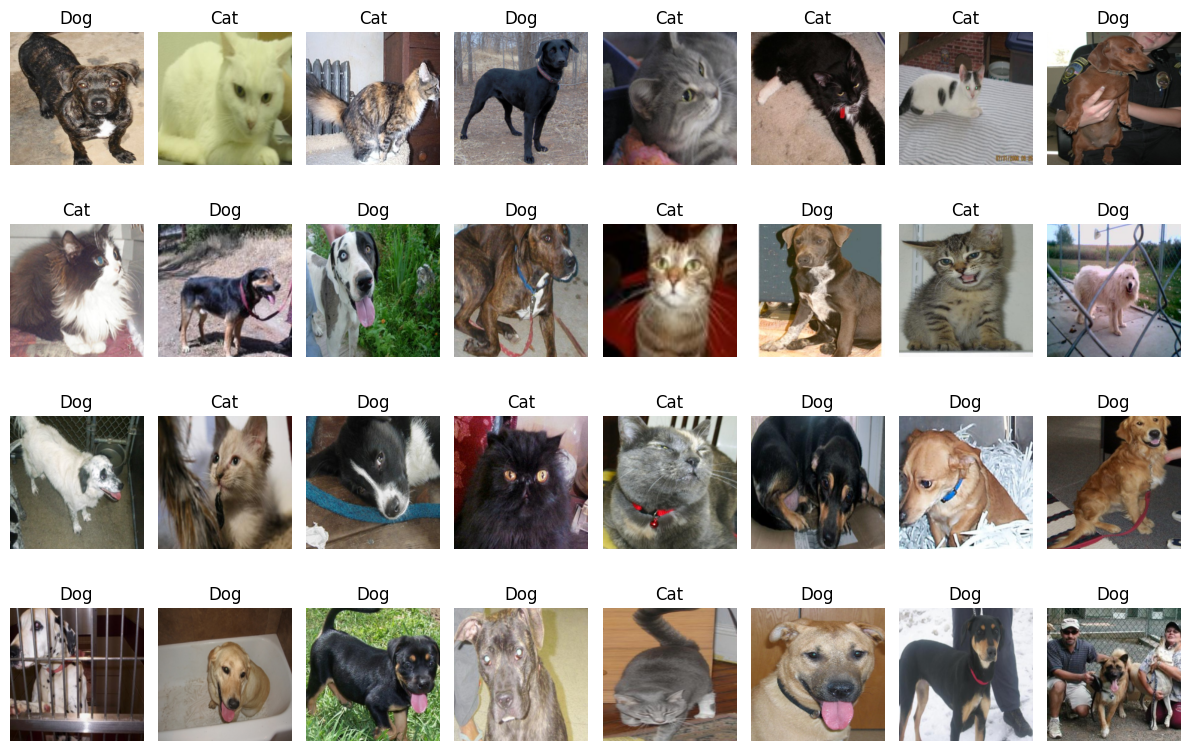

In [12]:
inv_mean = torch.tensor(mean).view(3,1,1)
inv_std  = torch.tensor(std).view(3,1,1)

def show_grid(imgs: torch.Tensor, labels: torch.Tensor, cols=8, rows=4):
    plt.figure(figsize=(12, 8))
    n = min(len(imgs), cols*rows)
    for i in range(n):
        img = imgs[i].cpu()
        img = img * inv_std + inv_mean
        img = torch.clamp(img, 0, 1)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(idx_to_class[int(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_grid(images, labels)


정규화 역변환 후 라벨 문자열로 확인합니다.

초기 배치에서 라벨 이름이 기대(Cat/Dog)와 맞는지 바로 육안 점검이 가능합니다.

In [13]:
weights = ResNet101_Weights.DEFAULT
model = models.resnet101(weights=weights)

# 백본 동결
for p in model.parameters():
    p.requires_grad = False

# 분류기 교체
model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(256, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.1),
    nn.Linear(64, 2)
)

model = model.to(device)
model


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:01<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

TorchVision 문서에 따라 weights 인자를 사용하며, ResNet101의 fc 입력 차원은 2048입니다.

In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.fc.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, lbls in loader:
        imgs = imgs.to(device, non_blocking=True)
        lbls = lbls.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = criterion(logits, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * imgs.size(0)
        correct += (logits.argmax(1) == lbls).sum().item()
        total += imgs.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, lbls in loader:
        imgs = imgs.to(device, non_blocking=True)
        lbls = lbls.to(device, non_blocking=True)
        logits = model(imgs)
        loss = criterion(logits, lbls)
        total_loss += loss.item() * imgs.size(0)
        correct += (logits.argmax(1) == lbls).sum().item()
        total += imgs.size(0)
    return total_loss/total, correct/total


/tmp/ipython-input-2593677292.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


혼합정밀, AdamW, CosineAnnealing 스케줄러를 사용합니다.

분류 문제에 표준적인 손실/최적화 세팅입니다. 혼합정밀은 GPU일 때만 활성화됩니다.

In [15]:
epochs = 5
best_acc = 0.0
best_path = "best_resnet101_catsdogs.pt"

for epoch in range(1, epochs+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = evaluate(model, test_loader)
    scheduler.step()
    dt = time.time() - t0
    print(f"[{epoch:02d}] train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | time={dt:.1f}s")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)

print("Best val_acc:", best_acc)


/tmp/ipython-input-2593677292.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[01] train_loss=0.0793 acc=0.9735 | val_loss=0.0484 acc=0.9854 | time=115.6s


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[02] train_loss=0.0432 acc=0.9845 | val_loss=0.0349 acc=0.9876 | time=110.8s


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[03] train_loss=0.0336 acc=0.9884 | val_loss=0.0429 acc=0.9848 | time=108.7s


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[04] train_loss=0.0329 acc=0.9870 | val_loss=0.0422 acc=0.9862 | time=112.7s


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[05] train_loss=0.0272 acc=0.9901 | val_loss=0.0292 acc=0.9888 | time=112.7s
Best val_acc: 0.9887977595519104


검증 정확도 기준으로 최고 모델을 저장합니다.

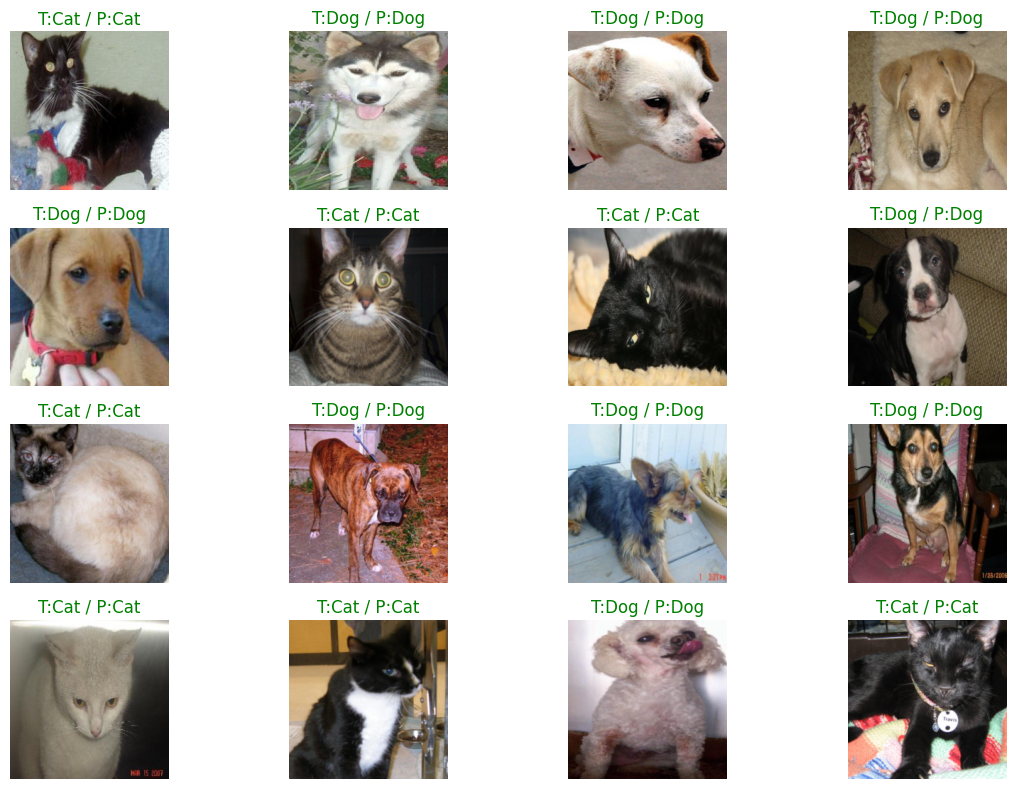

In [16]:
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

@torch.no_grad()
def predict_batch(imgs: torch.Tensor) -> torch.Tensor:
    logits = model(imgs.to(device))
    return logits.softmax(dim=1).cpu()

imgs, lbls = next(iter(test_loader))
probs = predict_batch(imgs)
preds = probs.argmax(dim=1)

def show_preds(imgs, lbls, preds, k=16):
    plt.figure(figsize=(12, 8))
    n = min(k, len(imgs))
    for i in range(n):
        img = imgs[i].cpu()
        img = img * inv_std + inv_mean
        img = torch.clamp(img, 0, 1)
        plt.subplot(4, 4, i+1)
        plt.imshow(img.permute(1,2,0))
        title = f"T:{idx_to_class[int(lbls[i])]} / P:{idx_to_class[int(preds[i])]}"
        plt.title(title, color=("green" if lbls[i]==preds[i] else "red"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_preds(imgs, lbls, preds, k=16)


저장된 최고 가중치를 로드하여 예측을 시각화합니다.

라벨 이름을 직접 표시해 라벨 정합성을 끝까지 확인합니다.

## 마지막 블록만 미세조정
layer4만 학습해 추가 향상을 노립니다.

In [17]:
for name, p in model.named_parameters():
    if name.startswith("layer4.") or name.startswith("fc."):
        p.requires_grad = True
    else:
        p.requires_grad = False

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

epochs_ft = 3
for epoch in range(1, epochs_ft+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = evaluate(model, test_loader)
    scheduler.step()
    print(f"[FT {epoch:02d}] train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")


/tmp/ipython-input-2593677292.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[FT 01] train_loss=0.0244 acc=0.9917 | val_loss=0.0220 acc=0.9898


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[FT 02] train_loss=0.0089 acc=0.9973 | val_loss=0.0288 acc=0.9898


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[FT 03] train_loss=0.0060 acc=0.9978 | val_loss=0.0433 acc=0.9904


백본 일부만 풀어 추가 학습합니다.

두 실험 모두 매우 높은 정확도에 도달했으며, 미세조정(레이어 일부 해제) 이후 소폭의 일반화 향상이 관측되지만, 에폭 진행에 따라 검증 손실이 다시 높아지는 경향이 보여 과적합 신호도 보입니다. 또한 나타난 경고 2종은 각각 최신 AMP API 변경과 일부 잔존 손상 이미지에 기인한 것으로, 코드/전처리에서 안전하게 처리할 수 있습니다.

기본 모델: val_acc가
0.9854
→
0.9888로 안정적으로 상승하며, 최종 Best
0.9888을 기록했습니다. 에폭 3~4에서 val_loss가 살짝 요동하지만 전반적으로 좋은 수렴입니다.

미세조정 모델: layer4+헤드 학습 후 val_acc가
0.9904까지 상승해 기본 대비 약
+
0.1
%p 개선이 확인됩니다. 다만 FT 02~03에서 train_loss는 크게 감소하는 반면 val_loss가 다시 상승해 과적합 가능성이 보입니다.

전이학습에서 “마지막 블록만 선택적 미세조정”은 보통 소폭의 이득을 주며, 레이어를 너무 많이 풀면 오히려 일반화가 악화될 수 있습니다. 관측된 패턴은 “선택적 미세조정 → 초기 개선 → 추가 에폭에서 일반화 이득 정체/후퇴”의 전형적 양상입니다.

두 설정 모두 상한에 근접한 정확도라 추가 이득은 제한적이며, 미세조정의 이점은 데이터/증강/정규화에 더 민감해집니다.